# Riverbed sensitivity analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('axes', labelsize=12) 
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title
import matplotlib.ticker as mtick
from matplotlib.ticker import LogFormatter 
import seaborn as sns
# from datetime import datetime
import datetime as dt
import datetime
from tqdm.notebook import tqdm
# import pillow
# import geopandas as gpd

from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import shapefile

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from IPython.display import HTML
from matplotlib import animation

In [4]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [5]:
import sys
# sys.path.append("/global/project/projectdirs/m1800/pin/github")
sys.path.append("/global/cfs/cdirs/m1800/pin/github/watershed-workflow")

import modvis.ATSutils as utils 
import modvis.ats_xdmf as xdmf
import modvis.transect_data as transect_data
import modvis.plot_vis_file as pv
import modvis.general_plots as gp
import modvis.utils as ut 
import modvis.colors as mcolors

import workflow

In [6]:
imodel = "transient_cal"
icase = "res150m_tck0.5m_k1.0md"
ires = "150m"
# imodel = "sensitivity_analysis_400"
# icase = "forward.10" # qetsc-mi forwrd run
# model = "model_250m-c64/spinup-rs150m-gauss3-rst"
work_dir = f"/global/cfs/cdirs/m1800/pin/github/ARW/"
model_dir = f"/global/cscratch1/sd/pshuai/ARW/model/runs/{imodel}-{icase}/"
data_dir = work_dir + "data/"
figure_dir = work_dir + "figures/riverbed_study/"
# data_dir = "/global/project/projectdirs/m1800/pin/yakima/data/"
# fig_dir = "/global/project/projectdirs/m1800/pin/yakima/figures/"

prefix = "ats_vis"
subsurface_mesh = f"{prefix}_mesh.h5"
surface_mesh = f"{prefix}_surface_mesh.h5"
subsurface_h5 = f"{prefix}_data.h5"
surface_h5 = f"{prefix}_surface_data.h5"
snow_mesh = f"{prefix}_snow_mesh.h5"

fname_snow_h5 = model_dir + f"{prefix}_snow_data.h5"
fname_snow_mesh = model_dir + f"{prefix}_snow_mesh.h5"
fname_subsurface_h5 = model_dir + f"{prefix}_data.h5"
fname_surface_h5 = model_dir + f"{prefix}_surface_data.h5"
fname_surface_mesh = model_dir + f"{prefix}_surface_mesh.h5"
fname_mesh = model_dir + f"{prefix}_mesh.h5"


# fname_combo_subsurface_h5 =  f"{prefix}_data-combo.h5"
# fname_combo_surface_h5 =  f"{prefix}_surface_data-combo.h5"
# fname_combo_snow_h5 =  f"{prefix}_snow_data-combo.h5"
# fname_subbasin = data_dir + "subbasin/subbasin_epsg2856.shp"
out_dir = data_dir + f"WW_outputs/"
fname_exchange_flux = data_dir + f"postprocessed/riverbed_study/{icase}-exchange_flux.csv"
# fname_water_balance = out_dir + "ARW_water_balance.csv"

# fname_exchange_flux_base = "/global/project/projectdirs/m1800/pin/yakima/output/ARW_250m-c128-riverbed/ARW_exchange_flux.csv"
data_dir = work_dir + "data/"
riverbed_dir = data_dir + "postprocessed/riverbed_study/"
fname_water_balance = data_dir + f"postprocessed/riverbed_study/{icase}-wb.csv"
fname_nexss = data_dir + "NEXSS/nhd_am_stream_nexss_monthly_annual_lateral_vertical_exchangeflux_log10_m_s.csv"
# fname_2Dmesh = f'../data/WW_outputs/{watershed_name}_riverbed-2Dmesh-{meshRes}.p'

fname_river_idx = out_dir + f"American_riverbed-2Dmesh-{ires}.p"
# fname_subbasin = data_dir + "NHDPlus_subbasin/subbasins.shp"
# fname_river_idx = "./data/preprocessed/American_river_idx-250m-riverbed.txt"
fname_river_shp = data_dir + "preprocessed/america_flowlines_nhdplusVAA-EPSG2856.shp"

fname_modis_snowcover = data_dir + "MODIS/ARW_MODIS_snowcover_2000-2021.csv"
fname_obs_q = data_dir + "USGS/American_discharge.csv"

In [7]:
colors = mcolors.colors('CB_color_cycle')

In [8]:
dates = [dt.datetime(2014,10,1), dt.datetime(2016,9,30)]

## Load data

## riverbed flux comparison

### permeability

In [10]:
storage_res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
storage_res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
storage_res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
storage_base = pd.read_csv(riverbed_dir + "res250m_tck0.0m_total-storage.csv", 
                                       index_col=0, parse_dates=True)

In [12]:
flux_res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
flux_res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
flux_res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
flux_base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)

In [14]:
var = 'average below water [mm/d]'

In [16]:
flux_res250m_0dot5m_K0dot1md[var].mean(), flux_res250m_0dot5m_K1md[var].mean(), flux_res250m_0dot5m_K10md[var].mean()

(16.63689229395212, 17.777577111060182, 19.319630065148928)

In [11]:
model_dict = {"models":[flux_base, flux_res250m_0dot5m_K0dot1md, flux_res250m_0dot5m_K1md, flux_res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

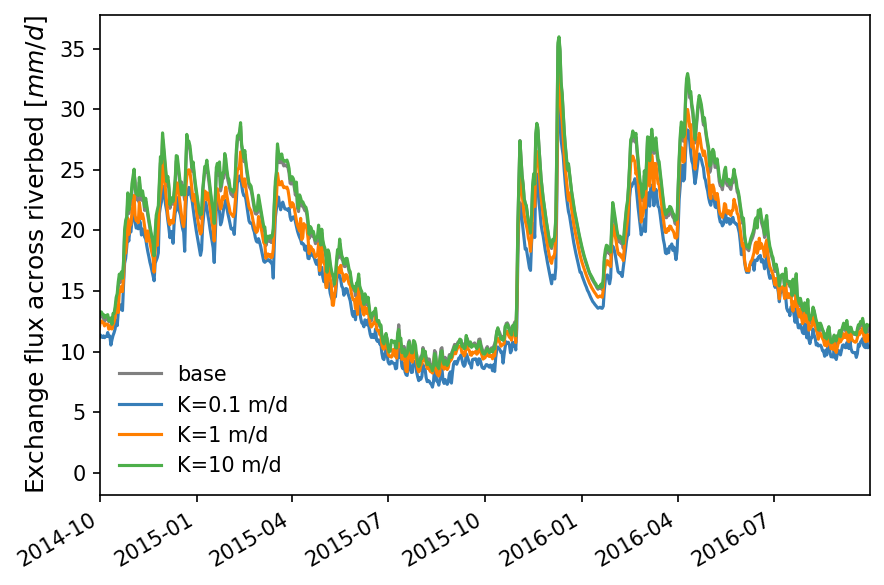

In [12]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Exchange flux across riverbed [$mm/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [37]:
fig.savefig(figure_dir + "riverbed_flux_K_comp.jpg", dpi=300)
plt.close(fig)

### thickness

In [17]:
var = 'average below water [mm/d]'

res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot25m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.25m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
res250m_1m_K1md = pd.read_csv(riverbed_dir + "res250m_tck1.0m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)

In [18]:
res250m_0dot25m_K1md[var].mean(), res250m_0dot5m_K1md[var].mean(), res250m_1m_K1md[var].mean()

(17.90022247658759, 17.777577111060182, 15.651383375909873)

In [92]:
model_dict = {"models":[base, res250m_0dot25m_K1md, res250m_0dot5m_K1md, res250m_1m_K1md],
             "labels":['base', 'thickness=0.25 m', 'thickness=0.5 m','thickness=1 m'],
             "colors": ['gray'] + colors[:3],
             }

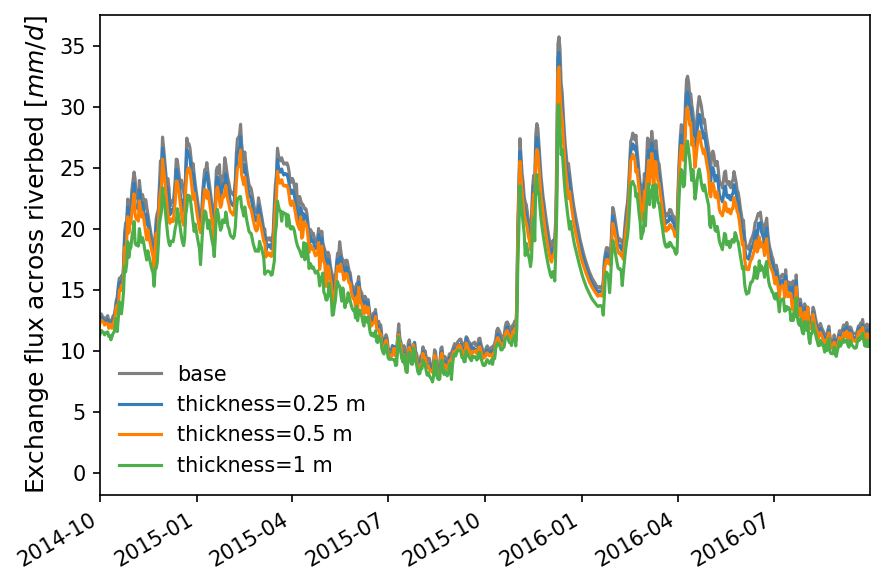

In [93]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Exchange flux across riverbed [$mm/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [94]:
fig.savefig(figure_dir + "riverbed_flux_thickness_comp.jpg", dpi=300)
plt.close(fig)

#### perm+thickness

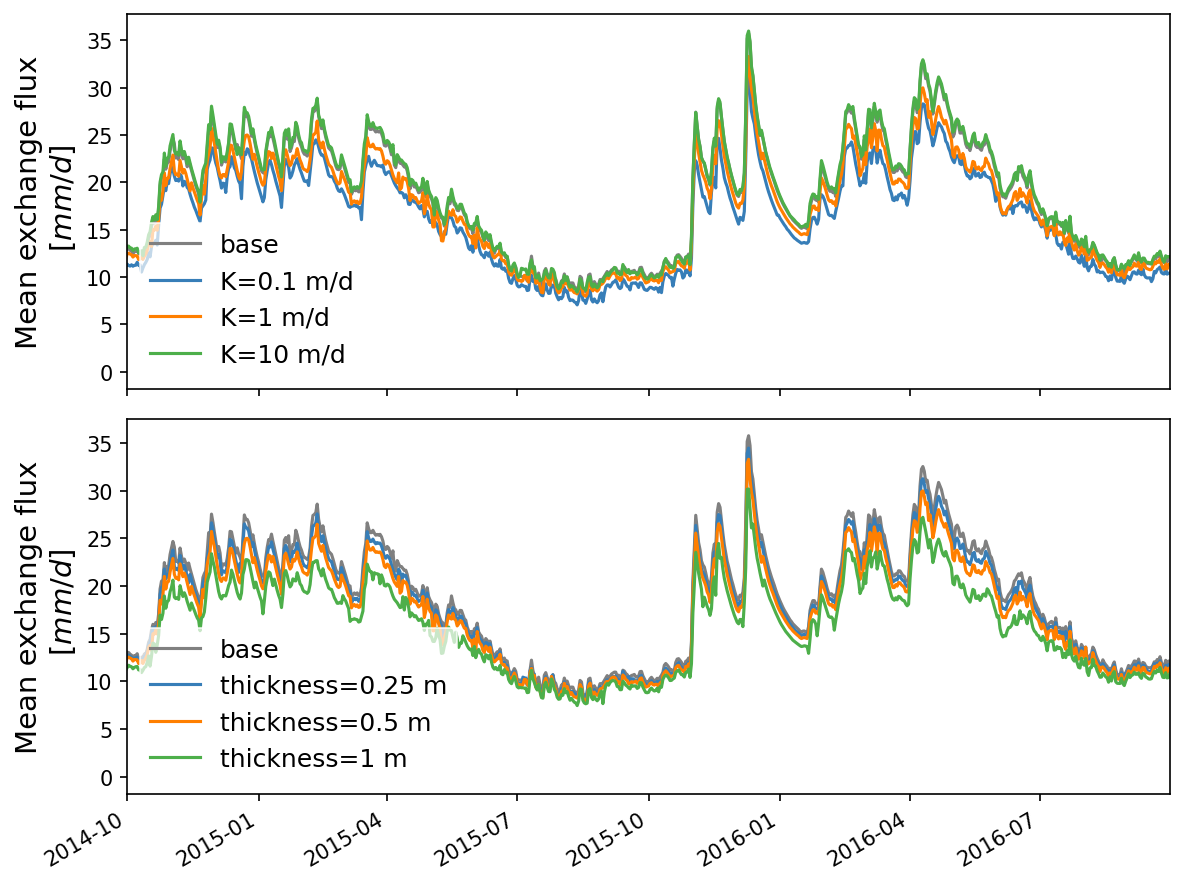

In [18]:
fontsize = 14
var = 'average below water [mm/d]'
fig, axes = plt.subplots(2, 1, figsize = (8, 6), sharex=True)

flux_res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
flux_res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
flux_res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
flux_base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
model_dict = {"models":[flux_base, flux_res250m_0dot5m_K0dot1md, flux_res250m_0dot5m_K1md, flux_res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

ax=axes[0]
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Mean exchange flux\n [$mm/d$]", fontsize = fontsize)


res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot25m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.25m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
res250m_1m_K1md = pd.read_csv(riverbed_dir + "res250m_tck1.0m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
model_dict = {"models":[base, res250m_0dot25m_K1md, res250m_0dot5m_K1md, res250m_1m_K1md],
             "labels":['base', 'thickness=0.25 m', 'thickness=0.5 m','thickness=1 m'],
             "colors": ['gray'] + colors[:3],
             }

ax=axes[1]
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Mean exchange flux\n [$mm/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [19]:
fig.savefig(figure_dir + "riverbed_flux_perm_thickness_comp.tif", dpi=300)
plt.close(fig)

### width

In [43]:
var = 'average below water [mm/d]'
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
res50m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res50m_tck0.5m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
res150m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res150m_tck0.5m_k1.0md-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-exchange_flux.csv", 
                                       index_col=0, parse_dates=True)

In [44]:
res50m_0dot5m_K1md[var].mean(), res150m_0dot5m_K1md[var].mean(), res250m_0dot5m_K1md[var].mean()

(45.81895714764479, 24.13653749361493, 17.777577111060182)

In [45]:
model_dict = {"models":[base, res250m_0dot5m_K1md, res150m_0dot5m_K1md, res50m_0dot5m_K1md],
             "labels":['base', '250 m', '150 m', '50 m'],
             "colors": ['gray'] + colors[:3],
             }

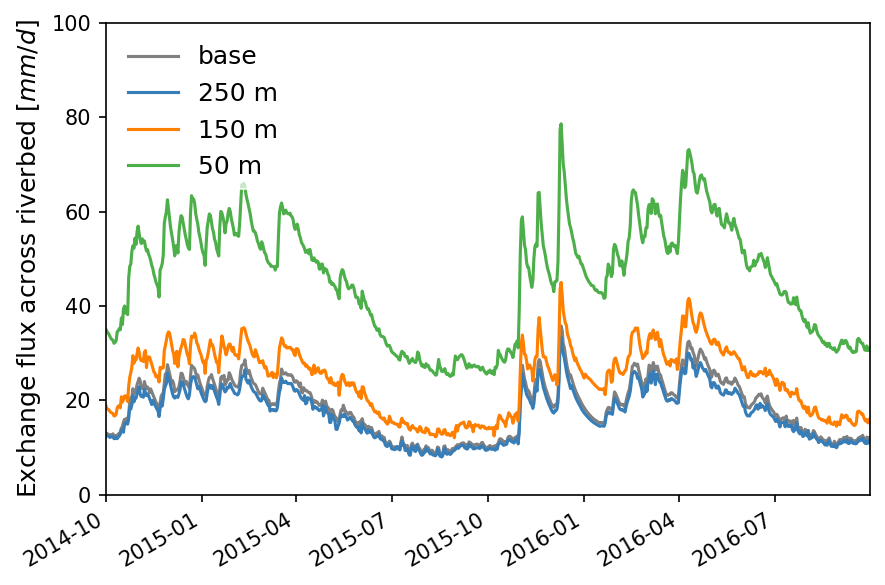

In [46]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylim([0,100])
ax.set_ylabel("Exchange flux across riverbed [$mm/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [13]:
fig.savefig(figure_dir + "riverbed_flux_width_comp.jpg", dpi=300)
plt.close(fig)

**Total flux across the riverbed**

In [48]:
var = 'sum below water [m^3/d]'

In [49]:
res50m_0dot5m_K1md[var].mean(), res150m_0dot5m_K1md[var].mean(), res250m_0dot5m_K1md[var].mean()

(178950.88888507904, 297602.12405751366, 357904.99087035144)

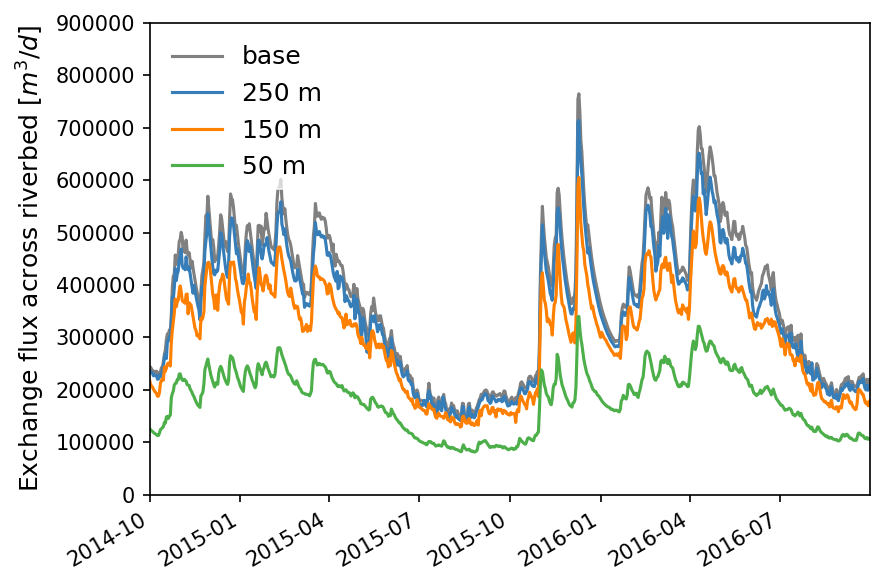

In [50]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
# ax.plot(base.index, base[var])
# res250m_0dot5m_K1md.plot('')

ax.set_xlim(dates)
ax.set_ylim([0,9e5])
ax.set_ylabel("Exchange flux across riverbed [$m^3/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [31]:
fig.savefig(figure_dir + "riverbed_flux_width_comp-sum.jpg", dpi=300)
plt.close(fig)

In [51]:
def cumsum_var(df):
    df = df.loc[dates[0]:dates[1], :].copy()
    df['cum_HEF [m^3]'] = df['sum below water [m^3/d]'].cumsum()
    
    return df

In [52]:
res250m_0dot5m_K1md = cumsum_var(res250m_0dot5m_K1md)
res50m_0dot5m_K1md = cumsum_var(res50m_0dot5m_K1md)
res150m_0dot5m_K1md = cumsum_var(res150m_0dot5m_K1md)
base = cumsum_var(base)

In [53]:
var = "cum_HEF [m^3]"

In [54]:
res250m_0dot5m_K1md[var][-1], res150m_0dot5m_K1md[var][-1], res50m_0dot5m_K1md[var][-1]

(254713869.31725556, 221631056.94235107, 131380959.82156757)

In [55]:
model_dict = {"models":[base, res250m_0dot5m_K1md, res150m_0dot5m_K1md, res50m_0dot5m_K1md],
             "labels":['base', '250 m', '150 m', '50 m'],
             "colors": ['gray'] + colors[:3],
             }

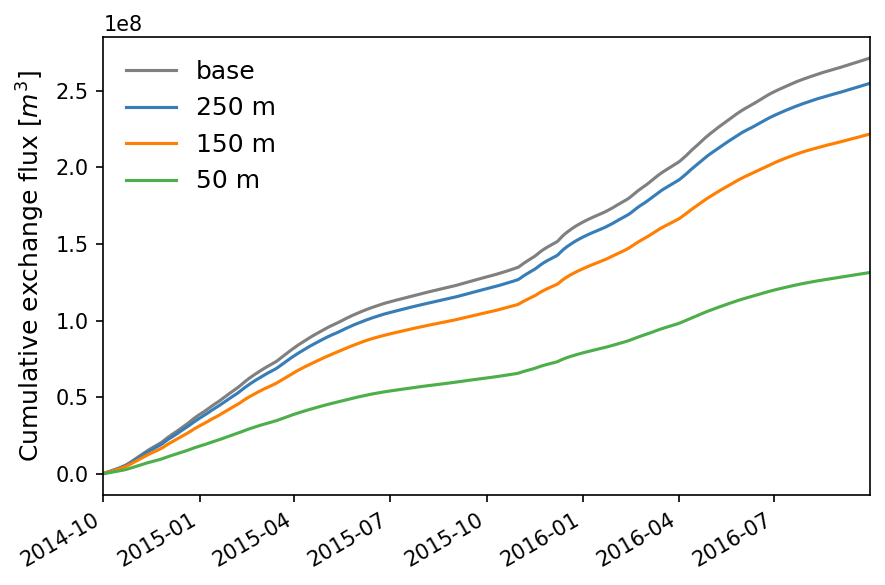

In [56]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Cumulative exchange flux [$m^3$]", fontsize = fontsize)

fig.autofmt_xdate()
fig.tight_layout()

In [37]:
fig.savefig(figure_dir + "riverbed_flux_width_comp-cumulative.jpg", dpi=300)
plt.close(fig)

#### all in one

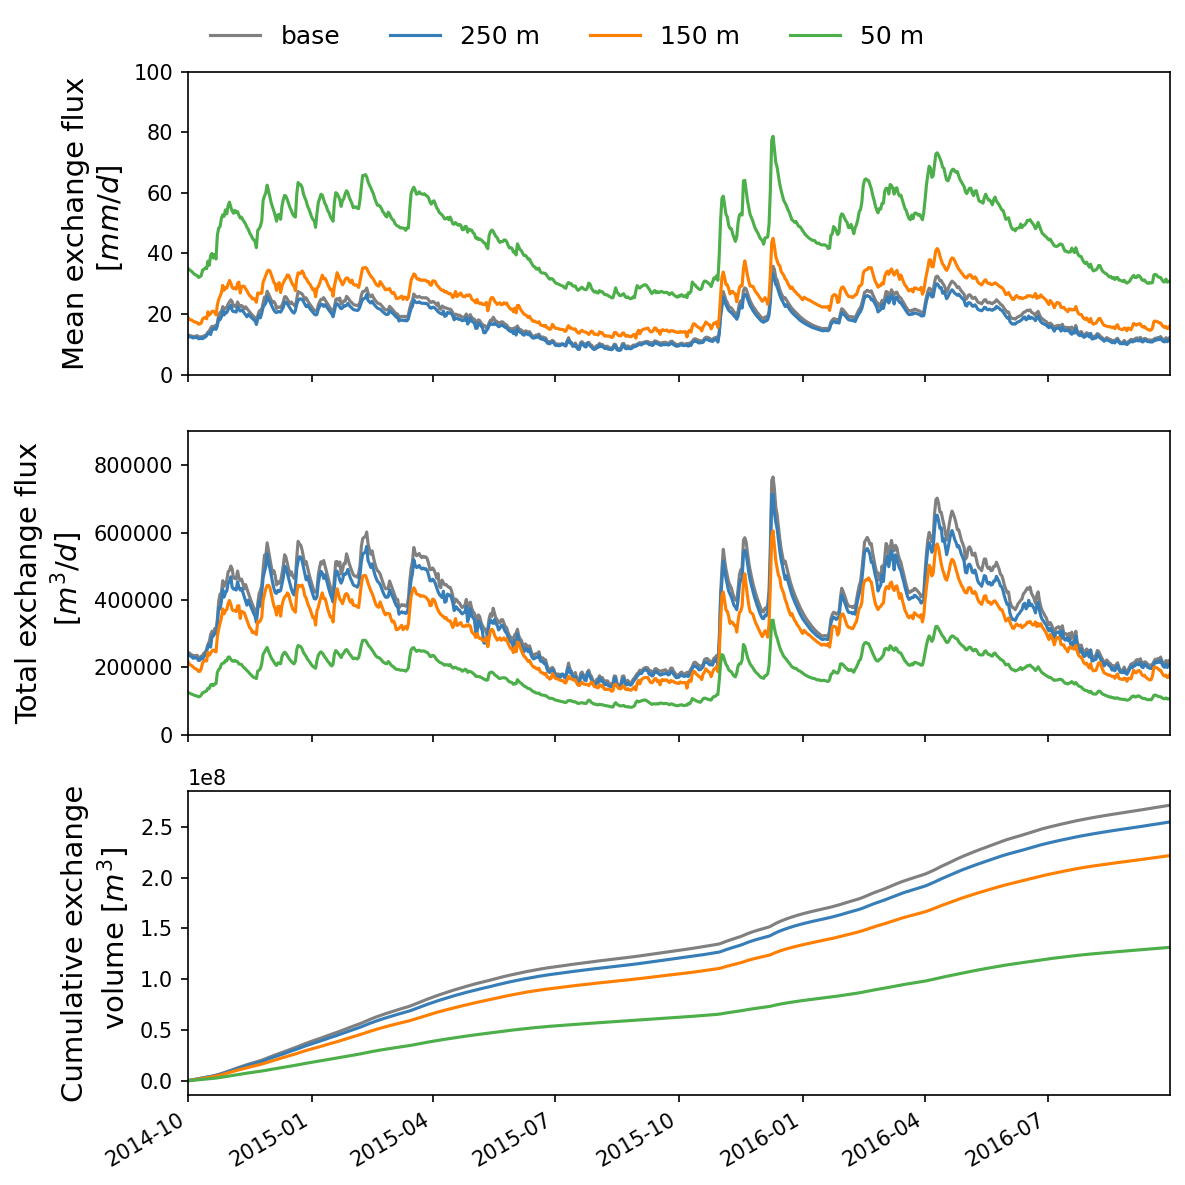

In [58]:
fontsize = 14
fig, axes = plt.subplots(3, 1, figsize = (8, 8), sharex=True)

ax=axes[0]
var = 'average below water [mm/d]'
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylim([0,100])
ax.set_ylabel("Mean exchange flux\n [$mm/d$]", fontsize=fontsize)
ut.custom_legend(model_dict['colors'], model_dict['labels'], loc = 'lower left', 
                 ax = ax, bbox_to_anchor =(0.0 , 1.0), ncol = 4, lw=1.5 )

ax=axes[1]
var = 'sum below water [m^3/d]'
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylim([0,9e5])
ax.set_ylabel("Total exchange flux\n [$m^3/d$]", fontsize=fontsize)
ax.legend('', frameon=False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(1,6))

ax=axes[2]
var = "cum_HEF [m^3]"
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Cumulative exchange\n volume [$m^3$]", fontsize=fontsize)
ax.legend('', frameon=False)

ax.ticklabel_format(axis='y', style='sci', scilimits=(1,6))
fig.autofmt_xdate()
fig.tight_layout()

In [59]:
fig.savefig(figure_dir + "riverbed_flux_width_comp-mean-total-cumu.jpg", dpi=300)
plt.close(fig)

In [60]:
fig.savefig(figure_dir + "riverbed_flux_width_comp-mean-total-cumu.tif", dpi=300)
plt.close(fig)

#### exchange flux across stream orders

In [9]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-exchange_flux-streamOrder.csv", 
                                       index_col=0)
res50m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res50m_tck0.5m_k1.0md-exchange_flux-streamOrder.csv", 
                                       index_col=0)
res150m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res150m_tck0.5m_k1.0md-exchange_flux-streamOrder.csv", 
                                       index_col=0)

In [10]:
def wide_to_long(df, res='250m'):
    df.columns = ['Flux1', 'Flux2', 'Flux3']
    df['width'] = res
    df['time'] = df.index
    # transform dataframe from wide to long
    df_new = pd.wide_to_long(df, stubnames='Flux', i = ['width', 'time'], j='order')
    
    
    return df_new.reset_index()

In [11]:
df_250m = wide_to_long(res250m_0dot5m_K1md, res='250m')
df_150m = wide_to_long(res150m_0dot5m_K1md, res='150m')
df_50m = wide_to_long(res50m_0dot5m_K1md, res='50m')

In [12]:
df = pd.concat([df_250m, df_150m, df_50m])

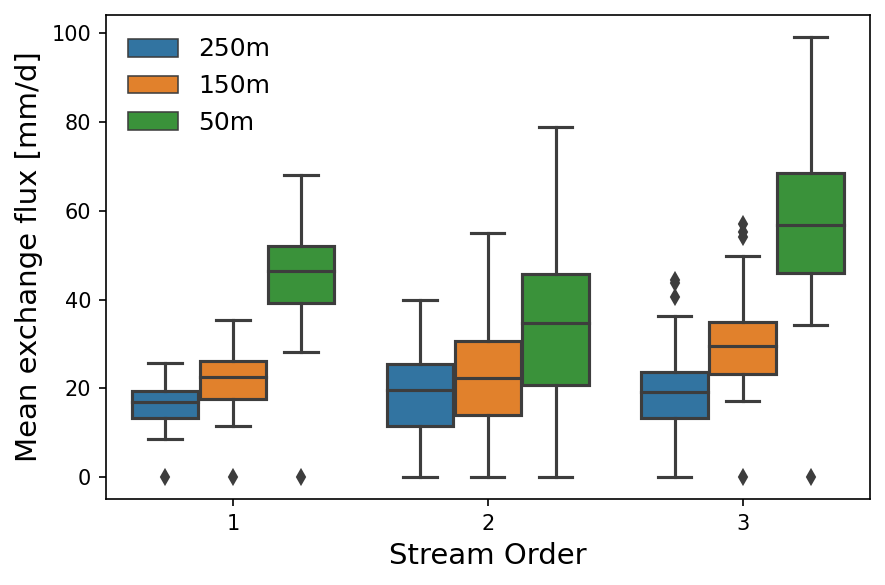

In [14]:
fig,ax=plt.subplots(1,1, figsize=(6,4))
sns.boxplot(data=df, x = 'order', y= 'Flux', hue = 'width', ax=ax)
ax.set_xlabel("Stream Order", fontsize=14)
ax.set_ylabel("Mean exchange flux [mm/d]", fontsize=14)
ax.legend(framealpha=1, frameon=False)
fig.tight_layout()

In [15]:
fig.savefig(figure_dir + "riverbed_flux_width_boxplots-transBG.png", dpi=300, transparent=True)
plt.close(fig)

In [16]:
fig.savefig(figure_dir + "riverbed_flux_width_boxplots.tif", dpi=300)
plt.close(fig)

#### Mann-Whiteney U test

To summarize: 

The following are not significant different:
- res250m-SOrder2 & res250m-SOrder3; 
- res150m-SOrder1 & res150m-SOrder2; 

In [14]:
ut.mann_whitney_test(res50m_0dot5m_K1md['1'], res50m_0dot5m_K1md['2'])

Statistics=311066.500, p=0.000
Different distributions (reject H0)


(311066.5, 9.544292756257333e-86)

In [21]:
ut.mann_whitney_test(res50m_0dot5m_K1md['1'], res50m_0dot5m_K1md['3'])

Statistics=304211.500, p=0.000
Different distributions (reject H0)


(304211.5, 9.829951986059224e-90)

In [22]:
ut.mann_whitney_test(res50m_0dot5m_K1md['2'], res50m_0dot5m_K1md['3'])

Statistics=149951.500, p=0.000
Different distributions (reject H0)


(149951.5, 6.251053758301331e-204)

In [15]:
ut.mann_whitney_test(res150m_0dot5m_K1md['1'], res150m_0dot5m_K1md['2'])

Statistics=592534.500, p=0.268
Same distributions (fail to reject H0)


(592534.5, 0.26827645370406294)

In [19]:
ut.mann_whitney_test(res150m_0dot5m_K1md['1'], res150m_0dot5m_K1md['3'])

Statistics=250051.500, p=0.000
Different distributions (reject H0)


(250051.5, 1.7294043078194695e-124)

In [20]:
ut.mann_whitney_test(res150m_0dot5m_K1md['2'], res150m_0dot5m_K1md['3'])

Statistics=352804.500, p=0.000
Different distributions (reject H0)


(352804.5, 1.8254765627790257e-63)

In [16]:
ut.mann_whitney_test(res250m_0dot5m_K1md['1'], res250m_0dot5m_K1md['2'])

Statistics=487570.500, p=0.000
Different distributions (reject H0)


(487570.5, 7.202031783067319e-15)

In [17]:
ut.mann_whitney_test(res250m_0dot5m_K1md['1'], res250m_0dot5m_K1md['3'])

Statistics=449097.500, p=0.000
Different distributions (reject H0)


(449097.5, 4.0813580434238834e-25)

In [18]:
ut.mann_whitney_test(res250m_0dot5m_K1md['2'], res250m_0dot5m_K1md['3'])

Statistics=594207.500, p=0.307
Same distributions (fail to reject H0)


(594207.5, 0.3066838841095956)

## Base flow comparison

### permeability

In [194]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)

res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)

res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md_total-storage.csv", 
                                       index_col=0, parse_dates=True)

base = pd.read_csv(riverbed_dir + "res250m_tck0.0m_total-storage.csv", 
                                       index_col=0, parse_dates=True)

In [195]:
model_dict = {"models":[base, res250m_0dot5m_K0dot1md, res250m_0dot5m_K1md, res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

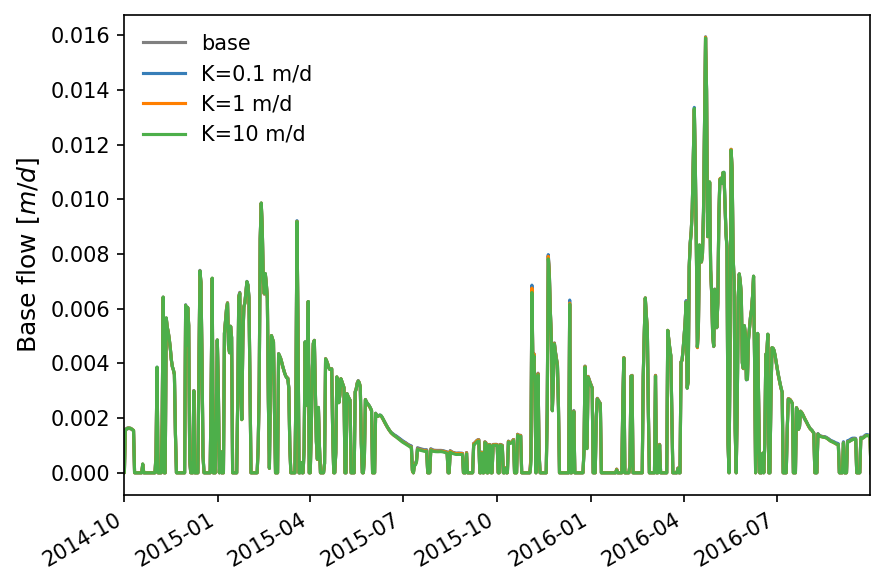

In [196]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=['base flow [m/d]'],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Base flow [$m/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [44]:
fig.savefig(figure_dir + "base_flow_K_comp.jpg", dpi=300)
plt.close(fig)

In [20]:
# for df in [res250m_0dot5m_K1md, res50m_0dot5m_K1md, base]:
def cumsum_var(df):
    df = df.loc[dates[0]:dates[1], :].copy()
    df['cum_base flow [m]'] = df['base flow [m/d]'].cumsum()
    
    return df

In [ ]:
res250m_0dot5m_K1md = cumsum_var(res250m_0dot5m_K1md)
res250m_0dot5m_K10md = cumsum_var(res250m_0dot5m_K10md)
res250m_0dot5m_K0dot1md = cumsum_var(res250m_0dot5m_K0dot1md)
base = cumsum_var(base)

In [198]:
model_dict = {"models":[base, res250m_0dot5m_K0dot1md, res250m_0dot5m_K1md, res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

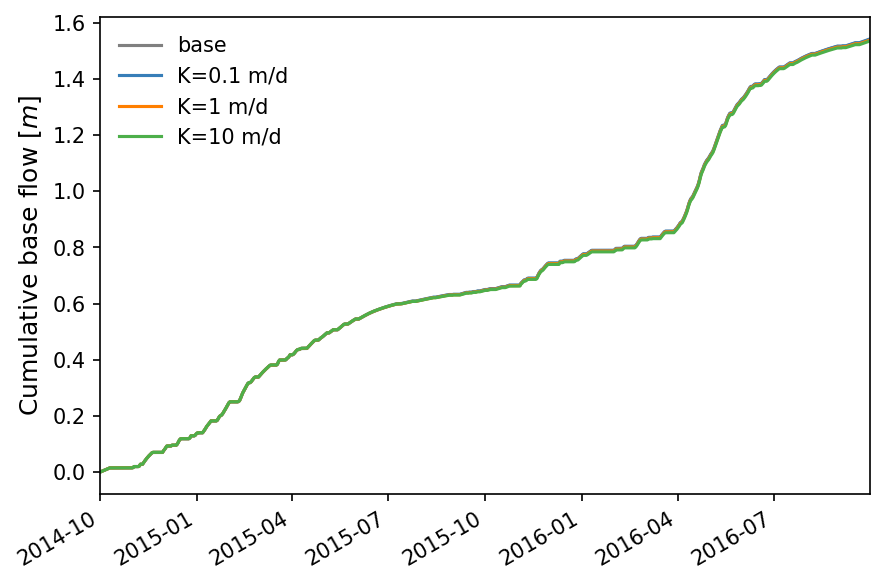

In [199]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=["cum_base flow [m]"],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Cumulative base flow [$m$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

### thickness

In [17]:
var = 'base flow [m/d]'

In [18]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot25m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.25m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
res250m_1m_K1md = pd.read_csv(riverbed_dir + "res250m_tck1.0m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m_total-storage.csv", 
                                       index_col=0, parse_dates=True)

In [19]:
model_dict = {"models":[base, res250m_0dot25m_K1md, res250m_0dot5m_K1md, res250m_1m_K1md],
             "labels":['base', 'thickness=0.25 m', 'thickness=0.5 m','thickness=1 m'],
             "colors": ['gray'] + colors[:3],
             }

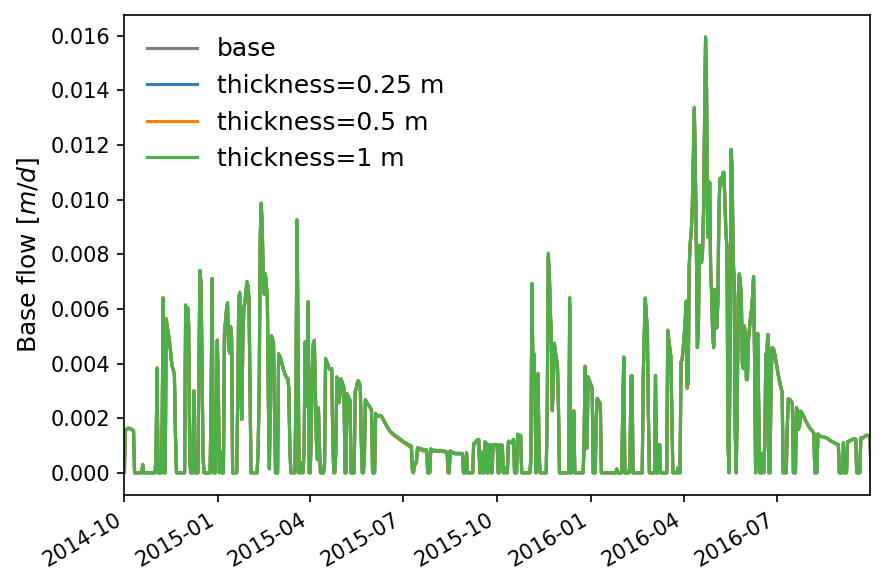

In [20]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Base flow [$m/d$]", fontsize = fontsize)

fig.autofmt_xdate()
fig.tight_layout()

In [73]:
fig.savefig(figure_dir + "riverbed_flux_thickness_comp.jpg", dpi=300)
plt.close(fig)

In [21]:
# for df in [res250m_0dot5m_K1md, res50m_0dot5m_K1md, base]:
def cumsum_var(df):
    df = df.loc[dates[0]:dates[1], :].copy()
    df['cum_base flow [m]'] = df['base flow [m/d]'].cumsum()
    
    return df

In [22]:
res250m_0dot5m_K1md = cumsum_var(res250m_0dot5m_K1md)
res250m_0dot25m_K1md = cumsum_var(res250m_0dot25m_K1md)
res250m_1m_K1md = cumsum_var(res250m_1m_K1md)
base = cumsum_var(base)

In [192]:
model_dict = {"models":[base, res250m_0dot25m_K1md, res250m_0dot5m_K1md, res250m_1m_K1md],
             "labels":['base', 'thickness=0.25 m', 'thickness=0.5 m','thickness=1 m'],
             "colors": ['gray'] + colors[:3],
             }

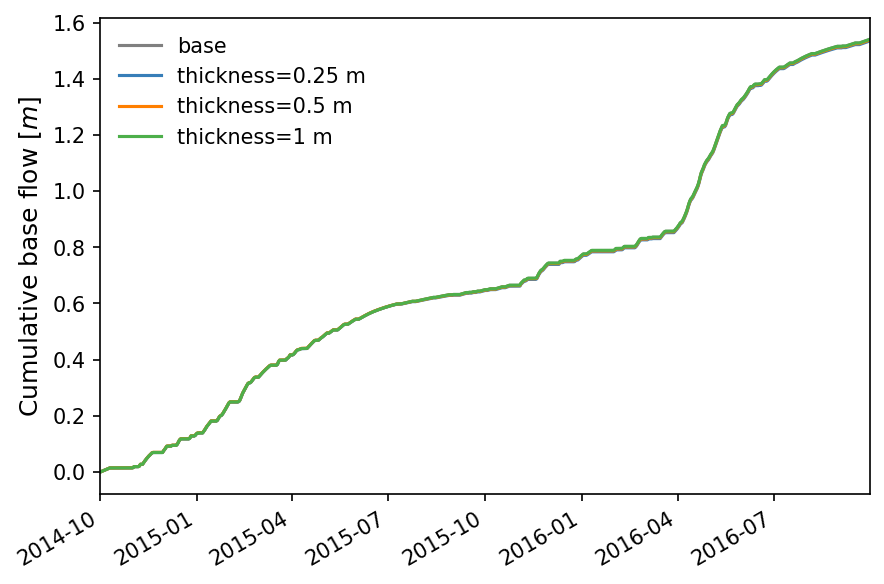

In [193]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=["cum_base flow [m]"],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Cumulative base flow [$m$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

### width

In [31]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
res50m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res50m_tck0.5m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
res150m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res150m_tck0.5m_k1.0md_total-storage.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m_total-storage.csv", 
                                       index_col=0, parse_dates=True)

In [32]:
# for df in [res250m_0dot5m_K1md, res50m_0dot5m_K1md, base]:
def cumsum_var(df):
    df = df.loc[dates[0]:dates[1], :].copy()
    df['cum_base flow [m]'] = df['base flow [m/d]'].cumsum()
    
    return df

In [33]:
res250m_0dot5m_K1md = cumsum_var(res250m_0dot5m_K1md)
res50m_0dot5m_K1md = cumsum_var(res50m_0dot5m_K1md)
res150m_0dot5m_K1md = cumsum_var(res150m_0dot5m_K1md)
base = cumsum_var(base)

In [34]:
model_dict = {"models":[base, res250m_0dot5m_K1md, res150m_0dot5m_K1md, res50m_0dot5m_K1md],
             "labels":['base', '250 m', '150 m', '50 m'],
             "colors": ['gray'] + colors[:3],
             }

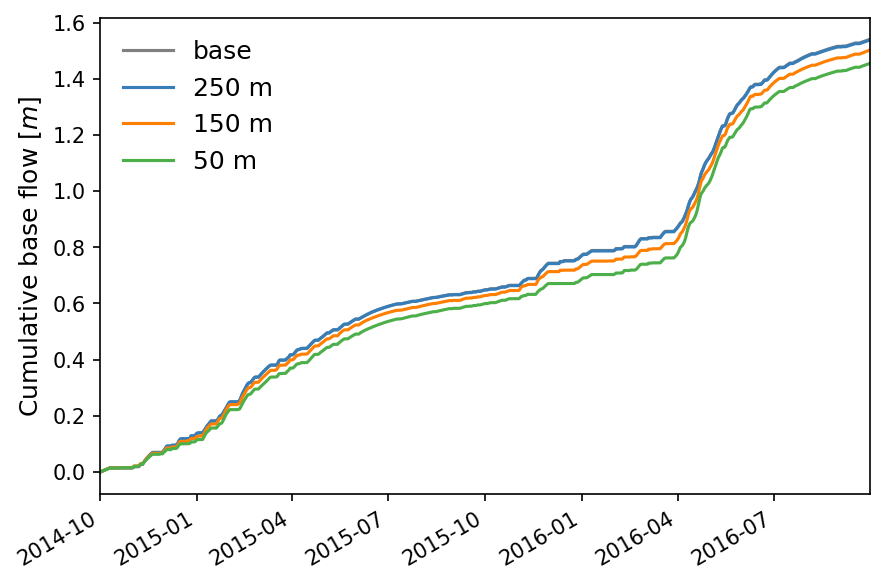

In [35]:
var = 'cum_base flow [m]'

fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
# base[var].plot(ax=ax, zorder=0)
ax.set_xlim(dates)
ax.set_ylabel("Cumulative base flow [$m$]", fontsize = fontsize)
ax.set_xlabel('')
plt.legend(frameon=False)

fig.autofmt_xdate()
fig.tight_layout()

In [60]:
fig.savefig(figure_dir + "cumu-baseflow_width_comp.jpg", dpi=300)
plt.close(fig)

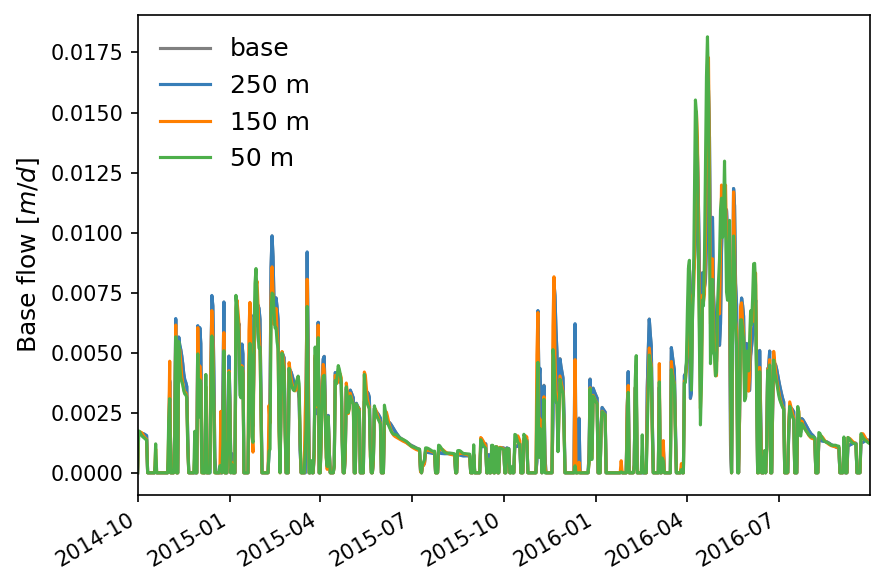

In [36]:
var = 'base flow [m/d]'

fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Base flow [$m/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [62]:
fig.savefig(figure_dir + "baseflow_width_comp.jpg", dpi=300)
plt.close(fig)

#### all in one

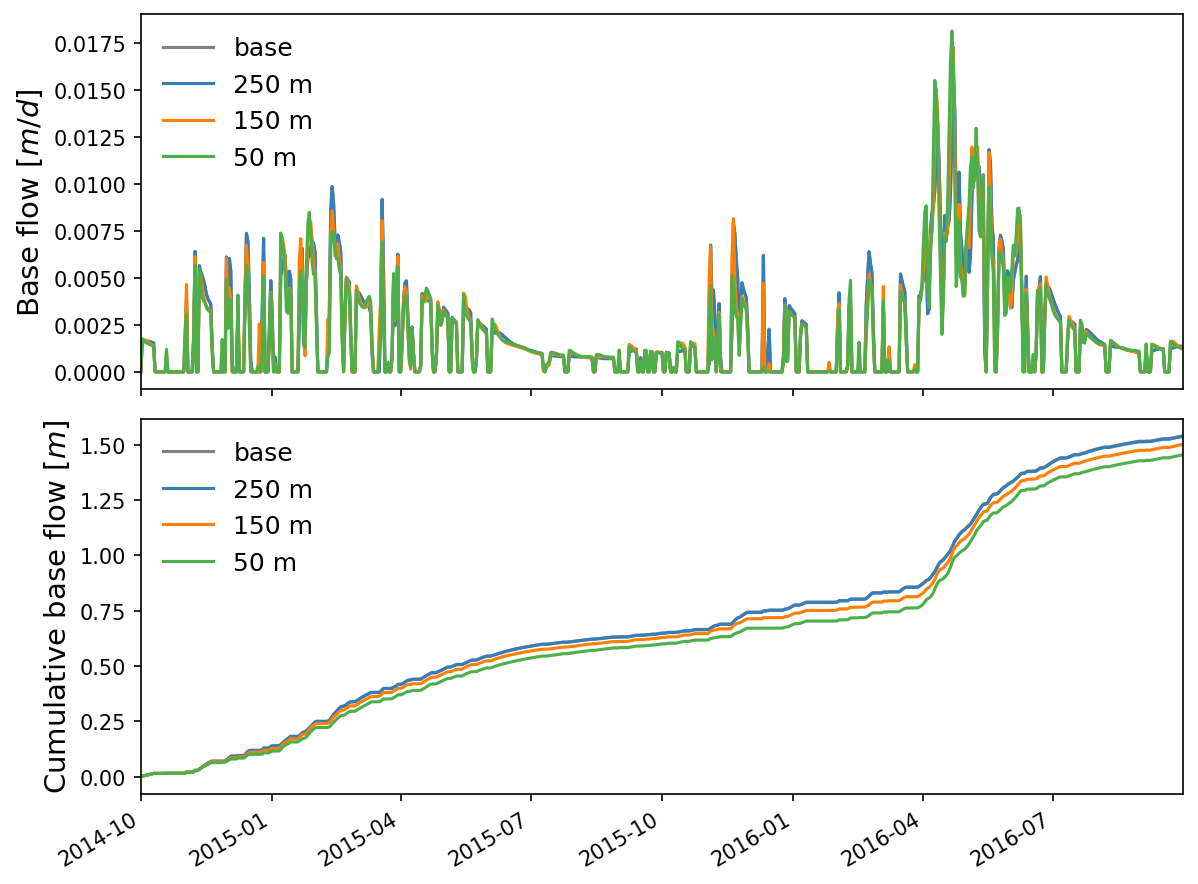

In [40]:
var = 'base flow [m/d]'

fontsize = 14
fig, axes = plt.subplots(2, 1, figsize = (8, 6), sharex=True)
ax=axes[0]
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Base flow [$m/d$]", fontsize = fontsize)
ax.legend(frameon=False, loc='upper left')

ax=axes[1]
var = 'cum_base flow [m]'
# fontsize = 12
# fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
# base[var].plot(ax=ax, zorder=0)
ax.set_xlim(dates)
ax.set_ylabel("Cumulative base flow [$m$]", fontsize = fontsize)
ax.set_xlabel('')
ax.legend(frameon=False, loc='upper left')

# fig.autofmt_xdate()
# fig.tight_layout()



fig.autofmt_xdate()
fig.tight_layout()


In [41]:
fig.savefig(figure_dir + "baseflow_width_comp-2in1.jpg", dpi=300)
plt.close(fig)

In [42]:
fig.savefig(figure_dir + "baseflow_width_comp-2in1.tif", dpi=300)
plt.close(fig)

## riverbed ET comparison

### permeability

**total ET**

In [46]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md-ET.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-ET.csv", 
                                       index_col=0, parse_dates=True)

In [47]:
model_dict = {"models":[base, res250m_0dot5m_K0dot1md, res250m_0dot5m_K1md, res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

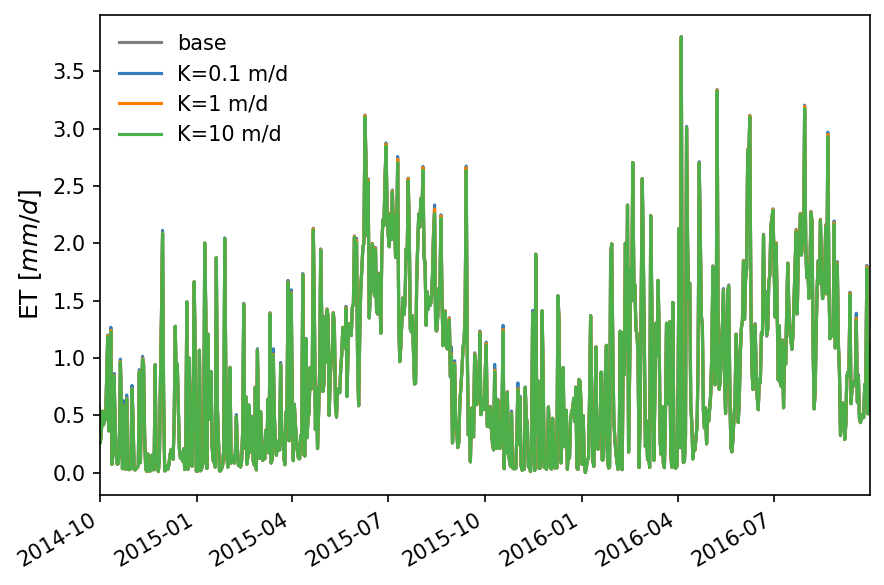

In [48]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=['average [mm/d]'],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("ET [$mm/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [49]:
fig.savefig(figure_dir + "ET_K_comp.jpg", dpi=300)
plt.close(fig)

**transpiration**

In [50]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-T.csv", 
                                       index_col=0, parse_dates=True)

res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md-T.csv", 
                                       index_col=0, parse_dates=True)

res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md-T.csv", 
                                       index_col=0, parse_dates=True)

base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-T.csv", 
                                       index_col=0, parse_dates=True)

In [51]:
model_dict = {"models":[base, res250m_0dot5m_K0dot1md, res250m_0dot5m_K1md, res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

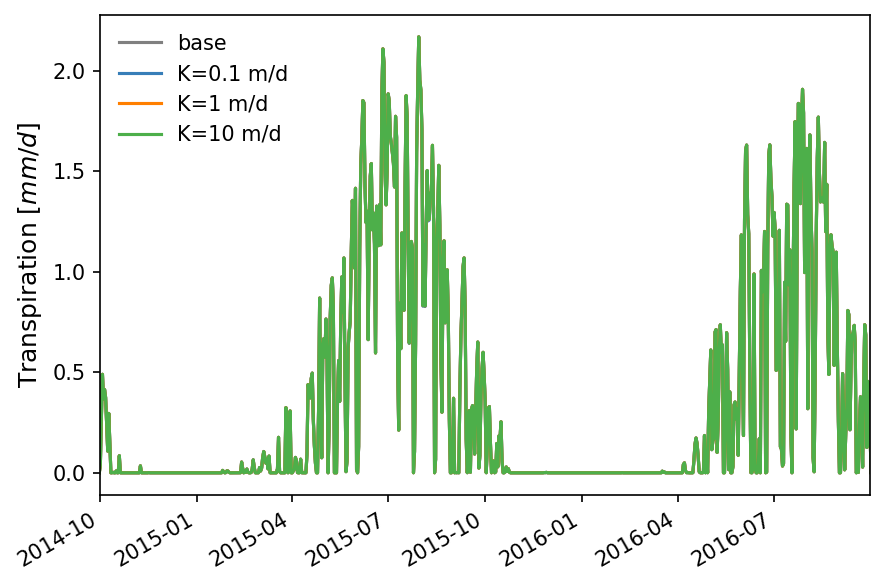

In [53]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=['average [mm/d]'],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Transpiration [$mm/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [54]:
fig.savefig(figure_dir + "transpiration_K_comp.jpg", dpi=300)
plt.close(fig)

**evaporation**

In [55]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-E.csv", 
                                       index_col=0, parse_dates=True)

res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md-E.csv", 
                                       index_col=0, parse_dates=True)

res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md-E.csv", 
                                       index_col=0, parse_dates=True)

base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-E.csv", 
                                       index_col=0, parse_dates=True)

In [56]:
model_dict = {"models":[base, res250m_0dot5m_K0dot1md, res250m_0dot5m_K1md, res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

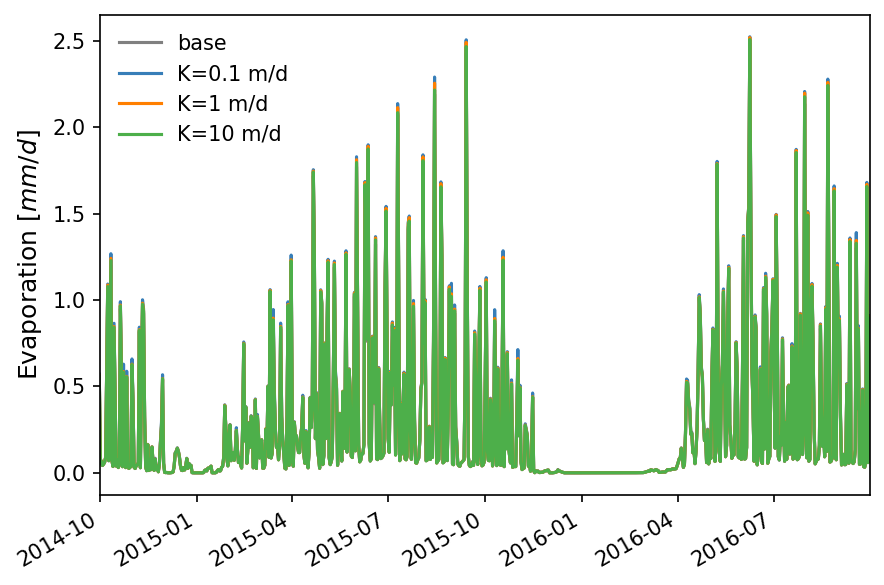

In [57]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=['average [mm/d]'],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Evaporation [$mm/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [58]:
fig.savefig(figure_dir + "evaporation_K_comp.jpg", dpi=300)
plt.close(fig)

### thickness

In [99]:
var = 'average [mm/d]'

In [100]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot25m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.25m_k1.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
res250m_1m_K1md = pd.read_csv(riverbed_dir + "res250m_tck1.0m_k1.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-ET.csv", 
                                       index_col=0, parse_dates=True)

In [101]:
model_dict = {"models":[base, res250m_0dot25m_K1md, res250m_0dot5m_K1md, res250m_1m_K1md],
             "labels":['base', 'thickness=0.25 m', 'thickness=0.5 m','thickness=1 m'],
             "colors": ['gray'] + colors[:3],
             }

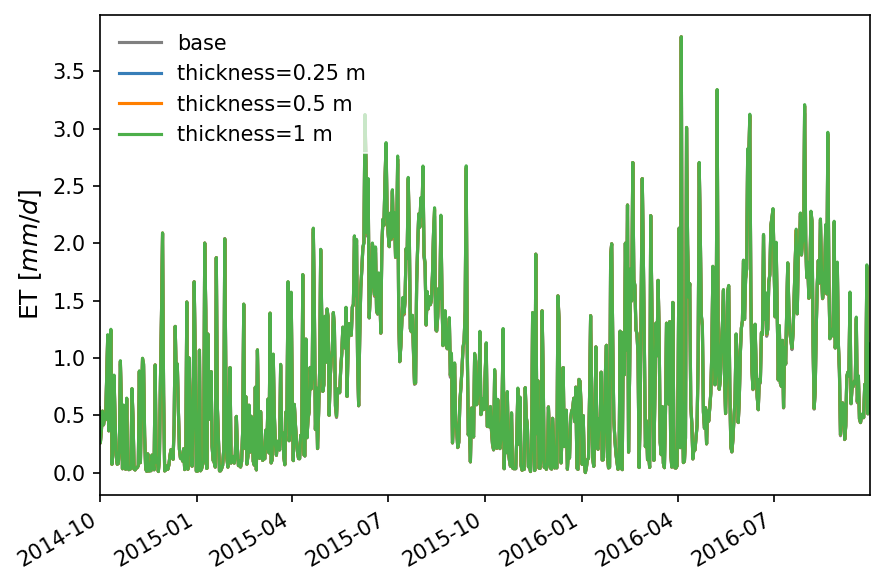

In [103]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("ET [$mm/d$]", fontsize = fontsize)

fig.autofmt_xdate()
fig.tight_layout()

In [104]:
fig.savefig(figure_dir + "riverbed_ET_thickness_comp.jpg", dpi=300)
plt.close(fig)

### width

In [33]:
var = 'average [mm/d]'

res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
res50m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res50m_tck0.5m_k1.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
res150m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res150m_tck0.5m_k1.0md-ET.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-ET.csv", 
                                       index_col=0, parse_dates=True)

In [34]:
var = "total evapotranspiration [mm d^-1]"

res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res50m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res50m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res150m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res150m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-wb.csv", 
                                       index_col=0, parse_dates=True)

In [35]:
model_dict = {"models":[base, res250m_0dot5m_K1md, res150m_0dot5m_K1md, res50m_0dot5m_K1md],
             "labels":['base', 'width=250 m', 'width=150 m', 'width=50 m'],
             "colors": ['gray'] + colors[:3],
             }

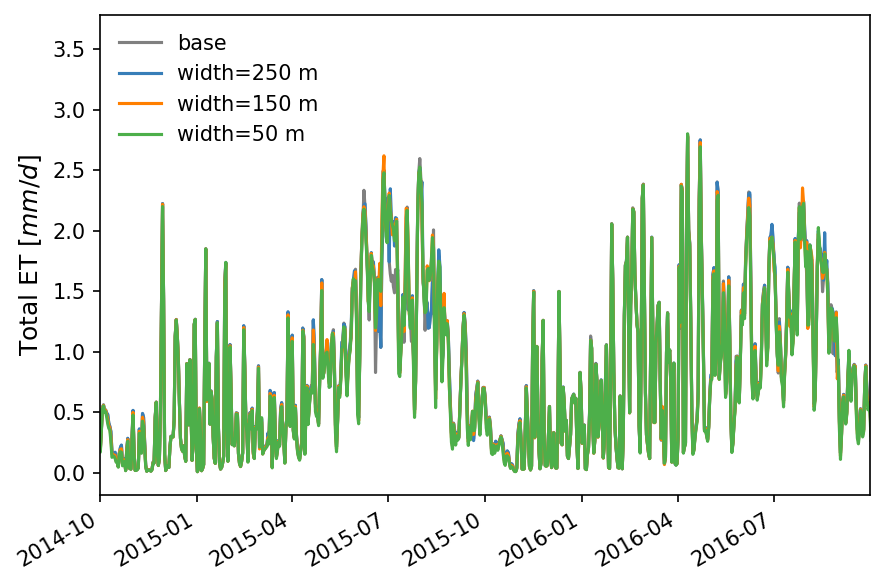

In [36]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Total ET [$mm/d$]", fontsize = fontsize)

fig.autofmt_xdate()
fig.tight_layout()

In [37]:
fig.savefig(figure_dir + "riverbed_ET_width_comp.jpg", dpi=300)
plt.close(fig)

## Streamflow comparison

### permeability

In [65]:
var = "watershed boundary discharge [m^3/d]"

In [66]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot5m_K10md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k10.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot5m_K0dot1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k0.1md-wb.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-wb.csv", 
                                       index_col=0, parse_dates=True)

In [60]:
model_dict = {"models":[base, res250m_0dot5m_K0dot1md, res250m_0dot5m_K1md, res250m_0dot5m_K10md],
             "labels":['base', 'K=0.1 m/d', 'K=1 m/d','K=10 m/d'],
             "colors": ['gray'] + colors[:3],
             }

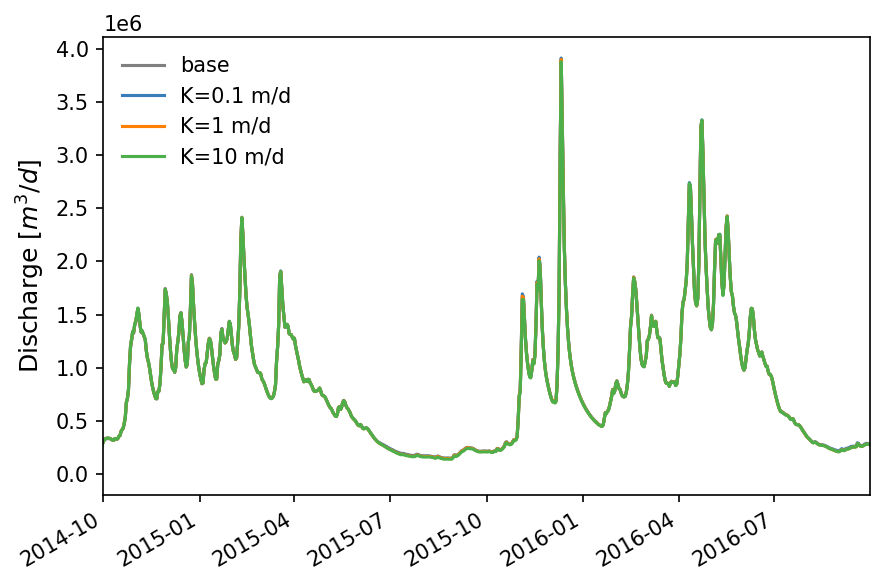

In [62]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Discharge [$m^3/d$]", fontsize = fontsize)


fig.autofmt_xdate()
fig.tight_layout()

In [63]:
fig.savefig(figure_dir + "Q_K_comp.jpg", dpi=300)
plt.close(fig)

### thickness

In [105]:
var = "watershed boundary discharge [m^3/d]"

In [106]:
res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res250m_0dot25m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.25m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res250m_1m_K1md = pd.read_csv(riverbed_dir + "res250m_tck1.0m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-wb.csv", 
                                       index_col=0, parse_dates=True)

In [107]:
model_dict = {"models":[base, res250m_0dot25m_K1md, res250m_0dot5m_K1md, res250m_1m_K1md],
             "labels":['base', 'thickness=0.25 m', 'thickness=0.5 m','thickness=1 m'],
             "colors": ['gray'] + colors[:3],
             }

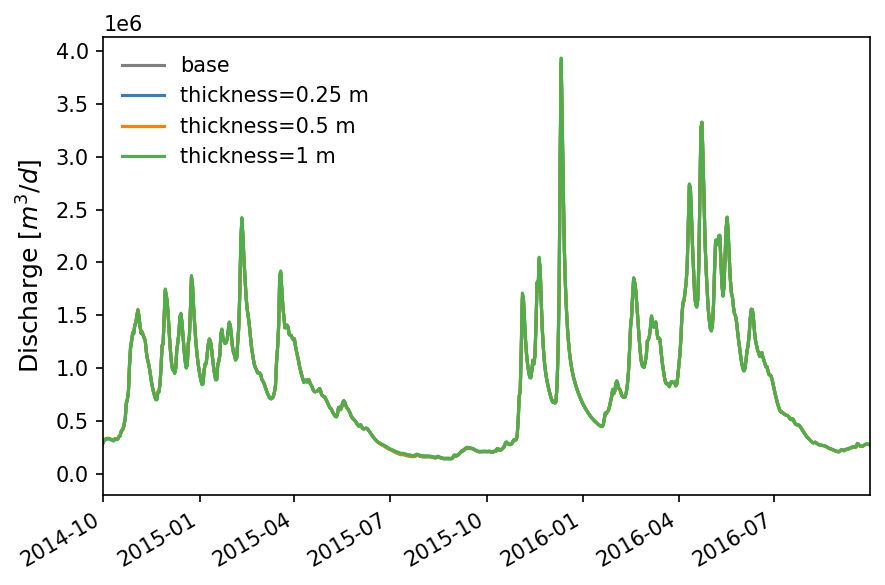

In [108]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Discharge [$m^3/d$]", fontsize = fontsize)

fig.autofmt_xdate()
fig.tight_layout()

In [109]:
fig.savefig(figure_dir + "Q_thickness_comp.jpg", dpi=300)
plt.close(fig)

### width

In [24]:
var = "watershed boundary discharge [m^3/d]"

res250m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res250m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res50m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res50m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
res150m_0dot5m_K1md = pd.read_csv(riverbed_dir + "res150m_tck0.5m_k1.0md-wb.csv", 
                                       index_col=0, parse_dates=True)
base = pd.read_csv(riverbed_dir + "res250m_tck0.0m-wb.csv", 
                                       index_col=0, parse_dates=True)

obs_q = ut.convertUSGSgauge(fname_obs_q, "discharge", datetime_col="dateTime")

obs_q[var] = obs_q['Discharge [m^3/d]']

2022-12-05 16:05:59,615 - root - INFO: insert nan


In [25]:
# for df in [res250m_0dot5m_K1md, res50m_0dot5m_K1md, base]:
def cumsum_var(df):
    df = df.loc[dates[0]:dates[1], :].copy()
    df['cum_Q [m]'] = df['watershed boundary discharge [m/d]'].cumsum()
    
    return df

In [26]:
res250m_0dot5m_K1md = cumsum_var(res250m_0dot5m_K1md)
res50m_0dot5m_K1md = cumsum_var(res50m_0dot5m_K1md)
res150m_0dot5m_K1md = cumsum_var(res150m_0dot5m_K1md)
base = cumsum_var(base)

In [27]:
model_dict = {"models":[base, res250m_0dot5m_K1md, res150m_0dot5m_K1md, res50m_0dot5m_K1md],
             "labels":['base', 'width=250 m', 'width=150 m', 'width=50 m'],
             "colors": ['gray'] + colors[:3],
             }

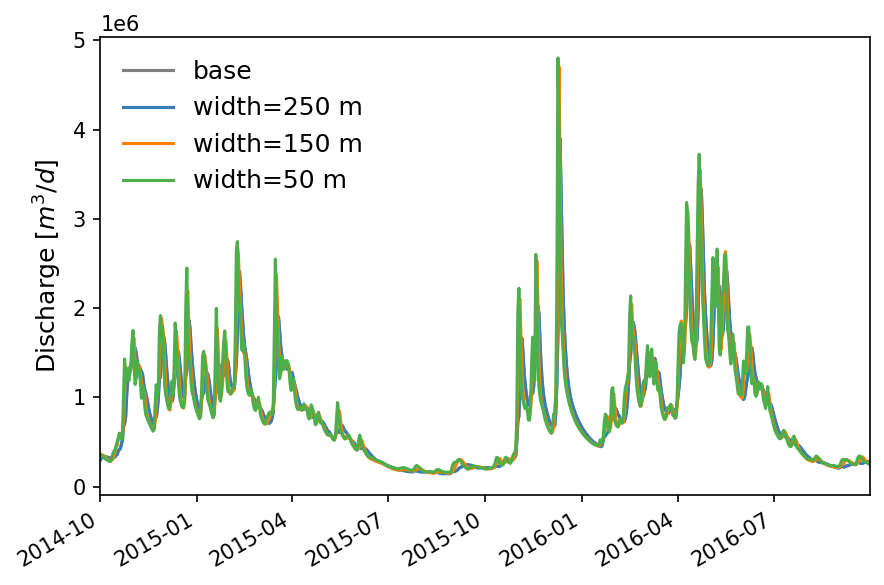

In [28]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Discharge [$m^3/d$]", fontsize = fontsize)

fig.autofmt_xdate()
fig.tight_layout()

In [41]:
fig.savefig(figure_dir + "Q_width_comp.jpg", dpi=300)
plt.close(fig)

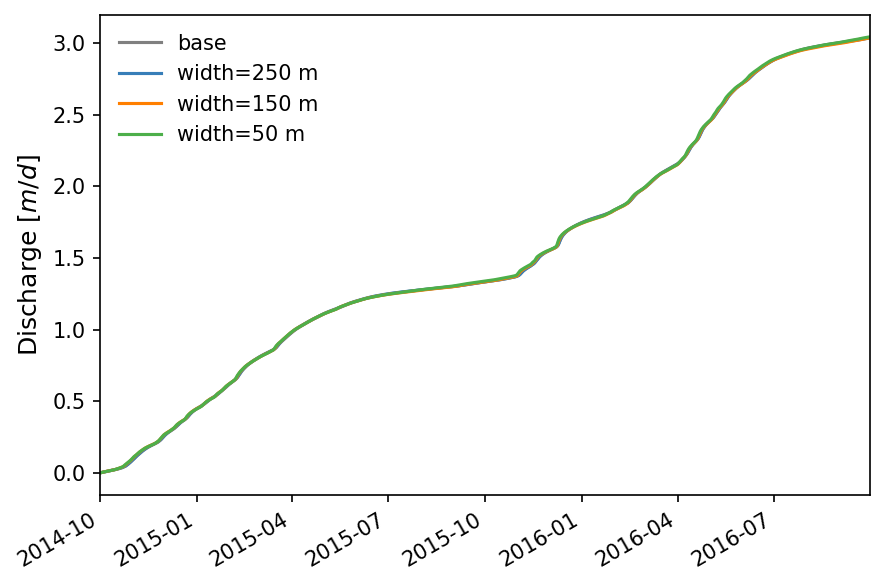

In [79]:
var = "cum_Q [m]"
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Discharge [$m/d$]", fontsize = fontsize)

fig.autofmt_xdate()
fig.tight_layout()

In [83]:
base[var][-1], res250m_0dot5m_K1md[var][-1], res150m_0dot5m_K1md[var][-1], res50m_0dot5m_K1md[var][-1]

(3.037635204227243, 3.0347671470756397, 3.034730476358146, 3.0423782239772317)

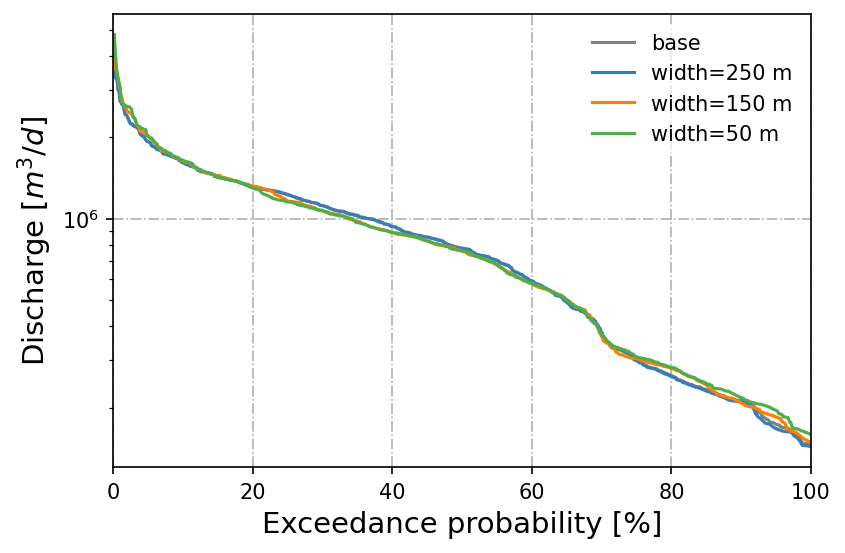

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.plot_FDC(model_dict['models'], model_dict['labels'], model_dict['colors'],
            # model_dict['linestyles'],
            # start_date = '2016-10-01', end_date = '2019-10-01', 
            time_index = obs_q[var].loc['2014-10-01':'2016-09-30'].dropna().index,
            var = var, ax=ax)

#### discharge

In [38]:
import matplotlib

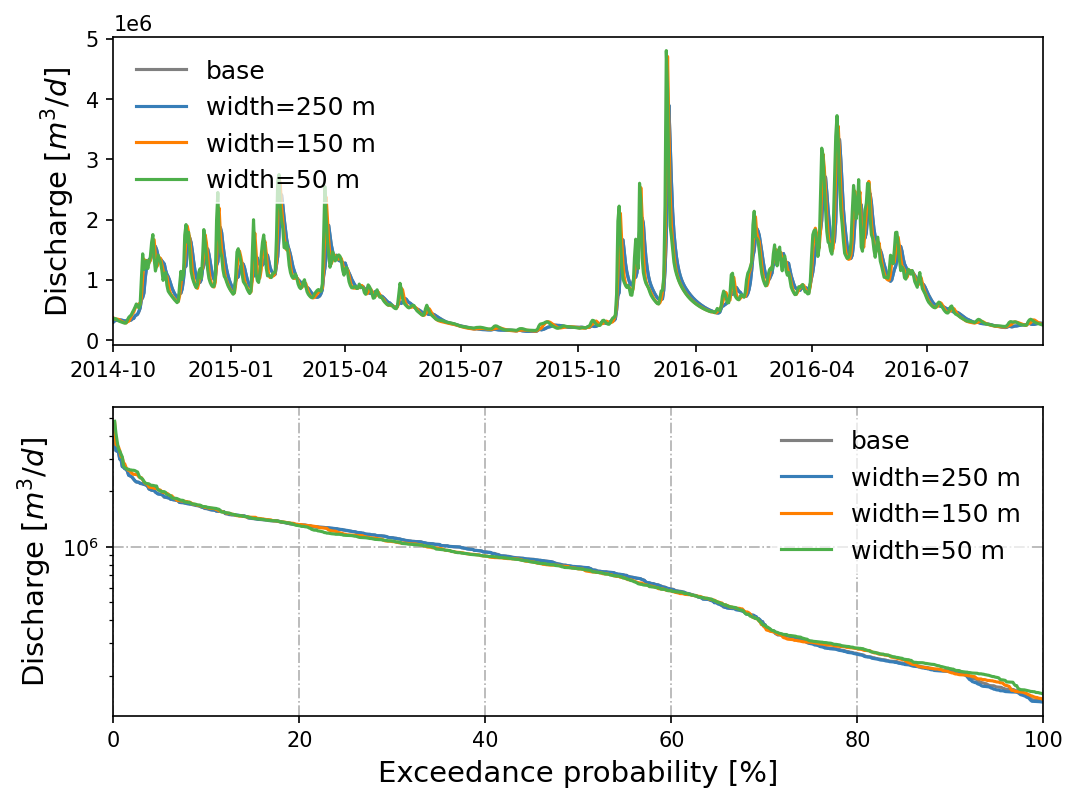

In [40]:
fontsize = 14
fig = plt.figure()
fig.set_size_inches(8, 6)
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[2,2])
gs.update(hspace = 0.2) # adjust vertical spacing b/w subplots
ax = plt.subplot(gs[0])
# fig, axes = plt.subplots(2, 1, figsize = (8, 6))

# ax = axes[0]
gp.varsComp_plot(model_dict['models'], variables=[var],
                labels = model_dict['labels'], colors= model_dict['colors'],
                 axes = ax)
ax.set_xlim(dates)
ax.set_ylabel("Discharge [$m^3/d$]", fontsize = fontsize)
# ax.tick_params(axis=u'x', which=u'minor',length=1)
ax.xaxis.set_tick_params(labelbottom=True)

# ax = axes[1]
ax = plt.subplot(gs[1])
gp.plot_FDC(model_dict['models'], model_dict['labels'], model_dict['colors'],
            # model_dict['linestyles'],
            # start_date = '2016-10-01', end_date = '2019-10-01', 
            time_index = obs_q[var].loc['2014-10-01':'2016-09-30'].dropna().index,
            var = var, ax=ax)

# fig.autofmt_xdate()
# fig.tight_layout()

In [41]:
fig.savefig(figure_dir + "Q_width_comp_FDC.jpg", dpi=300)
plt.close(fig)

In [43]:
model_obs_dict = {'models':[res250m_0dot5m_K1md, res150m_0dot5m_K1md, res50m_0dot5m_K1md, obs_q],
             'labels':['width=250 m', 'width=150 m', 'width=50 m', 'USGS'],
             'colors':colors[:3] + ['k'],
             'linestyles':['-']*4}

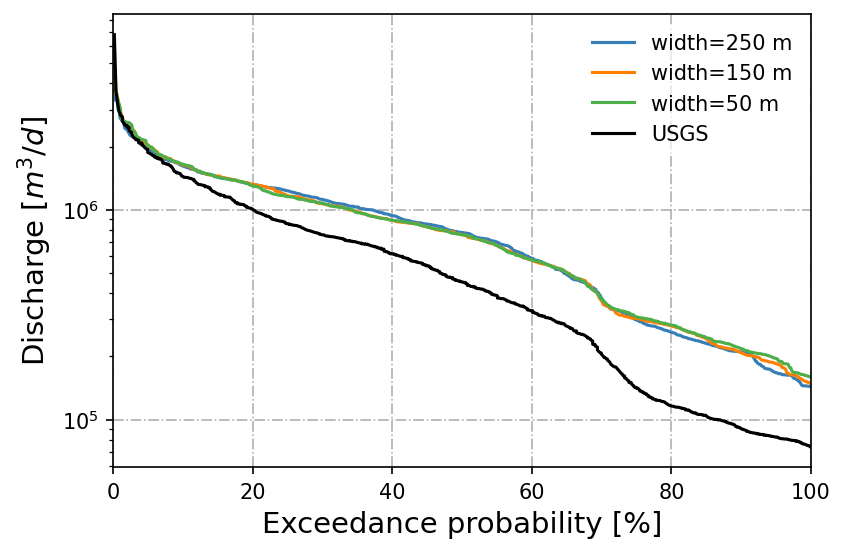

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
gp.plot_FDC(model_obs_dict['models'], model_obs_dict['labels'], model_obs_dict['colors'],
            model_obs_dict['linestyles'],
            # start_date = '2016-10-01', end_date = '2019-10-01', 
            time_index = obs_q[var].loc['2014-10-01':'2016-09-30'].dropna().index,
            var = var, ax=ax)